# Image style transfer with CNN

The goal is to generate new image from two input images the way that the output image contains the content of the first input image (spatial features) and the style (texture) of the another input image. The actual generator is implemented using convolutional neural network (CNN).

In other words, define a style transfer process which modifies the content image style while preserving its content close to the original. You can also think it as a process of merging two images together resulting in an output image containing aspects from both input images.

This notebook is an implementation of the method used to extract the artistic style of an image described in the following white paper (https://arxiv.org/pdf/1508.06576.pdf)

## Overview

#### Initialization
- Two images (content and style) from which the feature maps are extracted
    - Content image, the one containing all the spatial features
    - Style image, contains the overall style / texture
- The feature maps are used to adjust the features of random generated initial image to be as close as possible to the extracted content and style features
- A random generated image is passed as an input to the model
- After the style transfer process, the output image is overpainted to the input image by adjusting the pixel values during the process

#### Base model
- In order to extract the correct feature maps from the input images (spatial features from the content image, style features from the style image), a general machine learning model is needed
- There are several models which can be used as a base model to extract the feature maps
    - VGG16 is arguably the most popular one, at least for this purpose
    - Other models like VGG19, InceptionV3, and ResNet50
- The model is only used to get the right features, it will not be trained during the process (in other words, the model weights won't be update)

#### The problem definition
The style transfer process can be turned into a machine learning optimization problem. The optimization problem here is to minimize the loss function which is defined as follows:

Total loss = content loss + style loss

Content loss = The difference in content between initial input image and the content image
Style loss = The difference in style between the input and the style image

The smaller the total loss is, the closer the features of the output image are to the input images => matching content and style of the original images

#### The process description
- Random initial image
- Match the initial image's feature maps to the extracted feature map activations at chosen feature convolutional layer => backpropagates the input image pixels instead of the model weights

![NST Architecture](https://github.com/thushv89/exercises_thushv_dot_com/raw/dd79478562dd4c0f53472af5b79252404e030838/neural_style_transfer_light_on_math_ml/nst_architecture.jpg)

# Implementation

In [1]:
IMAGE_PARAMS = {
    'WIDTH': 512,
    'HEIGHT': 512,
    'CHANNELS': 3
}

IMAGE_DIMS = (1, IMAGE_PARAMS['HEIGHT'], IMAGE_PARAMS['WIDTH'], IMAGE_PARAMS['CHANNELS'])

# The mean value of the training data of the ImageNet in BGR format
VGG_MEAN = [123.68, 116.779, 103.939]

CONTENT_IMAGE_PATH = "img/venice_italy.jpg"
STYLE_IMAGE_PATH = "img/rain_princess.jpg"

CONTENT_WEIGHT = 0.0025
STYLE_WEIGHT = 8
TOTAL_VARIATION_WEIGHT = 1.1

# Gatys used layer "block2_conv2"
# Do experiments with other layers
# He only used one layer implying that it produces better results
CONTENT_LAYER = "block2_conv2"

STYLE_LAYERS = [
    'block1_conv2',
    'block2_conv2',
    'block3_conv3',
    'block4_conv3',
    'block5_conv3'
]

ITERATIONS = 20

In [2]:
from PIL import Image
from IPython.display import display

def resize_image(image_file_path):
    img = Image.open(image_file_path)
    img = img.resize((IMAGE_PARAMS['WIDTH'], IMAGE_PARAMS['HEIGHT']))
    return img

content_image = resize_image(CONTENT_IMAGE_PATH)
style_image = resize_image(STYLE_IMAGE_PATH)

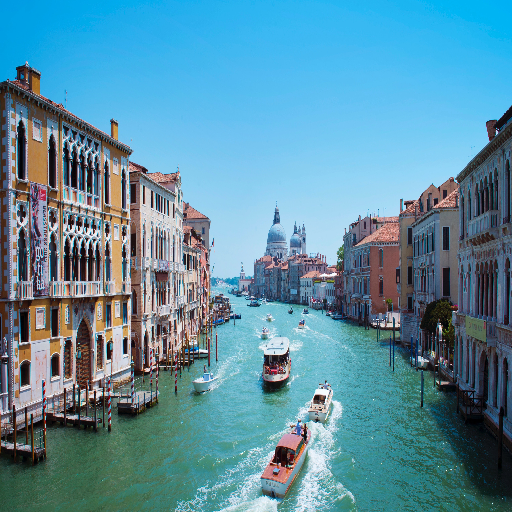

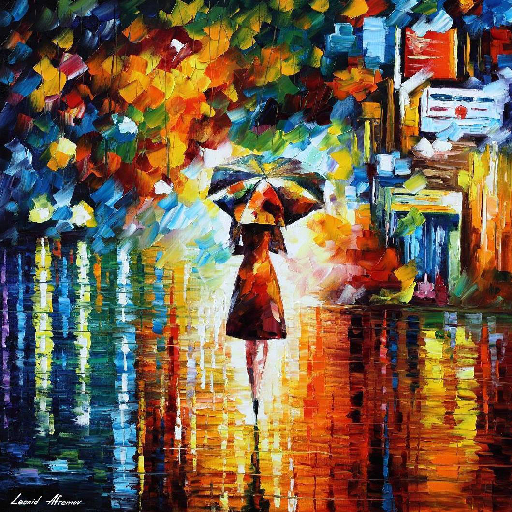

In [3]:
display(content_image)
display(style_image)

In [4]:
import numpy as np

# Normalize the image by the mean values of VGG and transformed to BGR (from RGB)
# This is required so the feature maps of VGG are applied correctly
def normalize_by(image, bgr_mean):
    image = np.asarray(image, dtype="float32")
    image = np.expand_dims(image, axis=0)

    image[:, :, :, 0] -= bgr_mean[2]
    image[:, :, :, 1] -= bgr_mean[1]
    image[:, :, :, 2] -= bgr_mean[0]

    # Change the order to BGR (because of VGG model uses it)
    return image[:, :, :, ::-1]

# VGG model

### VGG CNN architecture
- Visual Geometry Group (VGG) achieved the object classification error rate of 7% with this model
- Effective at object recognition

#### Network details
- Consists of 16 convolutional layers
- ReLU as the activation function
- 5 pooling layers
- 3 fully connected layers

![VGG vertical architecture](https://shafeentejani.github.io/assets/images/style_transfer/vgg_architecture_vertical.png)
![VGG architecture](http://www.cs.toronto.edu/~frossard/post/vgg16/vgg16.png)

In [5]:
from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

def build_vgg_input_tensor(content_image, style_image, generated_image):
    # Build the VGG16 model
    content_image = backend.variable(content_image)
    style_image = backend.variable(style_image)

    input_tensor = backend.concatenate([
        content_image,
        style_image,
        generated_image
    ], axis=0)
    
    return input_tensor

Using TensorFlow backend.


In [6]:
# Freeze the base model weights and biases, only the generated image pixel values are "trained"
def freeze_model(model):
    for layer in model.layers:
        layer.trainable = False
    return model

## Content loss

- The lower levels of CNNs are more focused on individual pixel values
- The higher levels are composed from the lower levels and thereby forming actual features of the image from the more basic values
- Calculate the root mean squared error between the activations of the generated image and the content image
- Different feature maps of the higher layers are activated when there's different objects in the images (https://arxiv.org/pdf/1311.2901.pdf)


In [7]:
def content_loss(content_features, generated_features):
    return backend.sum(backend.square(generated_features - content_features))

## Style loss
- Calculated with a set of layers (content used only one)
- From the quantifying point of view, style is the amount of correlation between features maps in a layer
- Style loss = the difference of correlation between the feature maps of generated image and the style image

In [8]:
# Also known as style matrix
def gram_matrix(x):
    features = backend.batch_flatten(
        backend.permute_dimensions(x, (2, 0, 1))
    )
    return backend.dot(features, backend.transpose(features))

def style_loss(style, generated, image_params):
    height = style.shape[0]
    width = style.shape[1]

    gram_style = gram_matrix(style)
    gram_generated = gram_matrix(generated)
    
    channels = image_params['CHANNELS']
    height = image_params['HEIGHT']
    width = image_params['WIDTH']
    # Total style loss of the layer at hand
    square_loss = backend.square(gram_generated - gram_style)
    
    # The hyper parameter from Gatys paper, does not really matter since beta will absorb this one
    multiplier = 1. / (4. * (channels ** 2) * ((height * width) ** 2))
    return backend.sum(multiplier * square_loss)

def total_style_loss(style_layers, layers, image_params):
    loss = backend.variable(0.)
    for layer_name in style_layers:
        layer_features = layers[layer_name]
        style_features = layer_features[1, :, :, :]
    
        combination_features = layer_features[2, :, :, :]
    
        style_loss_amount = style_loss(style_features, combination_features, image_params)
        
        # We could assign invidual weights for each layer but keep them equally important for now
        loss = loss + (1.0 / len(style_layers)) * style_loss_amount
    return loss

## Total variation loss
- Without any regularization, the result image is very grainy
- Smooth out the image with variation regularization among the neighbour pixels

In [9]:
def total_variation_loss(image):
    # Calculate how much horizontal and vertical neighbor pixels differ from each other
    # Add the difference as extra cost, this way the noise of the image can be regularized
    vertical_difference = backend.square(image[:, :-1, :-1, :] - image[:, 1:, :-1, :])
    horizontal_difference = backend.square(image[:, :-1, :-1, :] - image[:, :-1, 1:, :])

    return backend.sum(vertical_difference + horizontal_difference)

## Total loss

In [10]:
def total_loss(content_layer, style_layers, vgg_model, image_params):
    loss = backend.variable(0.)
    layers = dict([(layer.name, layer.output) for layer in vgg_model.layers])

    # Content loss
    content_layer_features = layers[content_layer]
    content_features = content_layer_features[0, :, :, :]
    generated_features = content_layer_features[2, :, :, :]
    loss = loss + CONTENT_WEIGHT * content_loss(content_features, generated_features)
  
    # Style loss
    loss = loss + STYLE_WEIGHT * total_style_loss(style_layers, layers, image_params)
    
    # Total variation, the noisiness of the images
    loss = loss + TOTAL_VARIATION_WEIGHT * total_variation_loss(result_image)
    return loss

# Evaluation

In [11]:
def evaluate_loss_and_gradients(generated_image, loss_and_gradients, img):
    img = img.reshape(IMAGE_DIMS)
    
    # Generated image is the current input to the model
    # We want to capture the new loss and gradients every round
    out = backend.function([generated_image], loss_and_gradients)([img])
    loss = out[0]
    gradients = out[1].flatten().astype("float64")
    return loss, gradients

In [12]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [13]:
# VGG normalized pixel values back to 0-255 range
def restore_image(img, vgg_mean):
    img = img.reshape((
        IMAGE_PARAMS['HEIGHT'],
        IMAGE_PARAMS['WIDTH'],
        IMAGE_PARAMS['CHANNELS']
    ))

    img = img[:, :, ::-1]
    
    img[:, :, 0] += vgg_mean[2]
    img[:, :, 1] += vgg_mean[1]
    img[:, :, 2] += vgg_mean[0]
    img = np.clip(img, 0, 255).astype("uint8")
    
    return img

def save_image(img_array, filename):
    image = Image.fromarray(img_array)
    image.save(filename)
    
    return image

In [14]:
from scipy.optimize import fmin_l_bfgs_b
from functools import partial

def random_initial_image(image_params):
    return np.random.uniform(
        -128.0,
        128.0,
        IMAGE_DIMS
    )

def optimize(img, result_image, loss_and_gradients, iterations, vgg_mean, save_iterations = True):
    evaluate = partial(evaluate_loss_and_gradients, result_image, loss_and_gradients)

    for i in range(iterations):
        img, loss, info = fmin_l_bfgs_b(
            evaluate,           # Function to minimise
            img.flatten(),      # Initial guess
            maxfun=20           # How many times loss and gradients are evaluated per iteration
        )
        
        print('Iteration %d, current loss %d' % (i, loss))
        
        if save_iterations:
            r = restore_image(img.copy(), vgg_mean)
            filename = './process/' + str(i) + '.png'
            save_image(r, filename)
    return img

In [15]:
# Read and normalize input images
content_image = normalize_by(content_image, VGG_MEAN)
style_image = normalize_by(style_image, VGG_MEAN)

result_image = backend.placeholder(IMAGE_DIMS)

# Build the VGG model with the input images + placeholder for the result image'
input_tensor = build_vgg_input_tensor(content_image, style_image, result_image)
vgg_model = VGG16(input_tensor=input_tensor, include_top=False)

# Freeze the model weights and biases, we are only "training" the pixel values of the result image
vgg_model = freeze_model(vgg_model)

initial_loss = total_loss(
    CONTENT_LAYER,
    STYLE_LAYERS,
    vgg_model,
    IMAGE_PARAMS
)

# Gradients return a list of tensors
loss_and_gradients = [initial_loss, *backend.gradients(initial_loss, result_image)]

initial_image = random_initial_image(IMAGE_PARAMS)
img = optimize(
    initial_image,
    result_image,
    loss_and_gradients,
    ITERATIONS,
    VGG_MEAN
)

Instructions for updating:
Colocations handled automatically by placer.
Iteration 0, current loss 94705336320
Iteration 1, current loss 49623273472
Iteration 2, current loss 32250193920
Iteration 3, current loss 24640032768
Iteration 4, current loss 20764170240
Iteration 5, current loss 18454577152
Iteration 6, current loss 16540866560
Iteration 7, current loss 14961874944
Iteration 8, current loss 13691234304
Iteration 9, current loss 12781548544
Iteration 10, current loss 11729780736
Iteration 11, current loss 11045951488
Iteration 12, current loss 10497251328
Iteration 13, current loss 9988507648
Iteration 14, current loss 9462403072
Iteration 15, current loss 9107743744
Iteration 16, current loss 8831358976
Iteration 17, current loss 8579835904
Iteration 18, current loss 8355531264
Iteration 19, current loss 8132709376
Iteration 20, current loss 7916132864
Iteration 21, current loss 7732000768
Iteration 22, current loss 7541835264
Iteration 23, current loss 7395485696
Iteration 24,

Iteration 205, current loss 4706555904
Iteration 206, current loss 4705499136
Iteration 207, current loss 4704301568
Iteration 208, current loss 4703174144
Iteration 209, current loss 4702042112
Iteration 210, current loss 4700903424
Iteration 211, current loss 4699782144
Iteration 212, current loss 4698743808
Iteration 213, current loss 4697677824
Iteration 214, current loss 4696651264
Iteration 215, current loss 4695695360
Iteration 216, current loss 4694774272
Iteration 217, current loss 4693979648
Iteration 218, current loss 4692746240
Iteration 219, current loss 4691556352
Iteration 220, current loss 4690712064
Iteration 221, current loss 4689667584
Iteration 222, current loss 4688818688
Iteration 223, current loss 4687924736
Iteration 224, current loss 4686925312
Iteration 225, current loss 4686120960
Iteration 226, current loss 4685307392
Iteration 227, current loss 4684375040
Iteration 228, current loss 4683053056
Iteration 229, current loss 4681684992
Iteration 230, current lo

KeyboardInterrupt: 

In [ ]:
# Save the final image
restored = restore_image(img, VGG_MEAN)
save_image(restored, "./process/final.png")

# Further experiments
- Change VGG pooling operation from max pooling to avg pooling, might produce better results

# Links
Great, detailed explanations and examples:
- https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-neural-style-transfer-ef88e46697ee
- https://towardsdatascience.com/neural-style-transfer-and-visualization-of-convolutional-networks-7362f6cf4b9b
- https://github.com/gsurma/style_transfer

### Images
Original images used in this notebook
- https://shafeentejani.github.io/assets/images/style_transfer/vgg_architecture_vertical.png
- http://www.cs.toronto.edu/~frossard/post/vgg16/vgg16.png
- https://github.com/thushv89/exercises_thushv_dot_com/raw/dd79478562dd4c0f53472af5b79252404e030838/neural_style_transfer_light_on_math_ml/nst_architecture.jpg